# Exercise 1
## Download, read and visualize H-SAF ASCAT SSM CDR and ISMN data

## Importing packages
Here we first import the python packages which we will need throughout this exercise. Don't worry about the warnings. 

In [1]:
import os, glob, sys #Miscellaneous operating system interfaces
import pandas as pd #Python data analysis library for working with data frames and basic analysis
import numpy as np
import ascat.h_saf as hsaf #Package for reading hsaf data
import matplotlib.pyplot as plt #Plotting library
from ismn.interface import ISMN_Interface #Package for reading ISMN data
import pytesmo.temporal_matching as tmatch #Package for temporal matching of two time series
import pytesmo.time_series.anomaly as ts_anom # Package for time series analysis and validation

/opt/conda/lib/python3.11/site-packages/ascat/h_saf.py:41: UserWarning: pygrib can not be imported GRIB files (H14) can not be read.
  warnings.warn(


## Set paths for data
Here we need to set the paths to where the data is stored. If you have stored all the data to the same folder, you will only need to change the path_test_data variable to your data folder. 

In [6]:
# change the username of the paths
path_test_data = f"/home/mvreugde/shared/120.110-2024S/Data"
workspace_path = f"/home/mvreugde/Documents"
print(os.path.isdir(path_test_data)) #check if the path is correct
print(os.path.isdir(workspace_path)) #check if the path is correct
h120_path = os.path.join(path_test_data, 'hsaf')
static_layer_path = os.path.join(path_test_data, 'static_layer')
grid_path = os.path.join(path_test_data,'warp5_grid')
#i created a folder ismn
ismn_path = os.path.join(workspace_path,'ismn')



True
True


## Read ISMN Data

To read ISMN data there is a package available on github, which is already installed here. A description and examples can be found here: https://ismn.readthedocs.io/en/latest/examples/interface.html

In the following cells we give you an example of how to read the data. The first time your data will be unzipped and takes a bit longer. 

In [7]:
# unzip the data and metadata
ismn_zipfile=glob.glob(os.path.join(ismn_path, '*.zip'))[0]
ismn_data = ISMN_Interface(ismn_zipfile)


Found existing ismn metadata in /home/mvreugde/Documents/ismn/python_metadata/Data_separate_files_header_20130301_20230313_9279_62H3_20230313.csv.


Network: [Stations]
 HOAL: ['Hoal_01', 'Hoal_02', 'Hoal_04', 'Hoal_05', 'Hoal_06', 'Hoal_07', 'Hoal_08', 'Hoal_09', 'Hoal_10', 'Hoal_11', 'Hoal_12', 'Hoal_13', 'Hoal_14', 'Hoal_15', 'Hoal_16', 'Hoal_17', 'Hoal_18', 'Hoal_19', 'Hoal_21', 'Hoal_22', 'Hoal_23', 'Hoal_24', 'Hoal_25', 'Hoal_26', 'Hoal_27', 'Hoal_28', 'Hoal_29', 'Hoal_30', 'Hoal_32', 'Hoal_33', 'Hoal_34', 'Hoal_35', 'Hoal_36']
Location number of the soil moisture data:  [72]
                     soil_moisture soil_moisture_flag soil_moisture_orig_flag
date_time                                                                    
2013-07-22 11:00:00          0.209                  G                       M
2013-07-22 12:00:00          0.209                  G                       M
2013-07-22 13:00:00          0.209                  G                       M
2013-07-22 14:00:00          0.209                  G                       M
2013-07-22 15:00:00          0.208                  G                       M


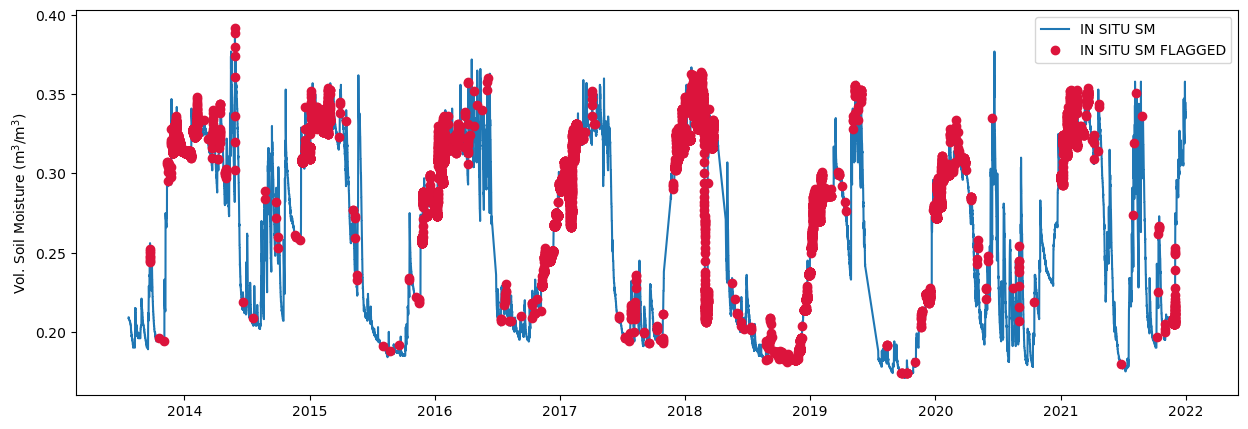

lon: 15.15468, lat: 48.15045


In [9]:
#check the available data (I dowloaded 3 stations in this example and I would like to use Hoal-17): 
print('Network: [Stations]\n',ismn_data.collection)
#get the location id for the specific network, station, variable and depth
ids=ismn_data.get_dataset_ids(variable='soil_moisture',max_depth=0.06,\
                              filter_meta_dict={'network':'HOAL', 'station':'Hoal_17'})
print('Location number of the soil moisture data: ', ids)
#we want to use the top soil moisture sensor, which is index number 0
insitu_ts, meta=ismn_data.read(ids[0],return_meta=True)
# print first five rows of the data and the metadata
print(insitu_ts.head(5))
# Let's also check what our time series look like including the masked values 

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(insitu_ts.loc[:,'soil_moisture'],  label='IN SITU SM')
ax.plot(insitu_ts.loc[insitu_ts['soil_moisture_flag']!='G','soil_moisture'],marker='o',c='crimson', lw=0, label='IN SITU SM FLAGGED')
ax.set_ylabel(r'Vol. Soil Moisture (m$^3$/m$^3$)')
ax.legend()
plt.show()

# We also need to obtain the longitude and latitude for our station, 
# so that we can read in the satellite data closest to our station.

lon, lat = meta['longitude','val'],meta['latitude','val']
print ('lon: {:.5f}, lat: {:.5f}'.format(lon, lat))



## Read H120 - Metop ASCAT SSM CDR 12.5 km sampling
We need to initialize the reader, where we need to set the paths of the data, the grid file and the static layers. 

Then the data can be read using either longitude and latitude or per gridpoint. You can find the grid of the H120 product here: 
http://rs.geo.tuwien.ac.at/dv/dgg/

The hsaf package automatically reads the data as a pandas dataframe. Now you can use the full functionality of pandas to do a first analysis of your dataset. 
You can have a quick look at the data by using the .head() function, showing you the data structure. For the meaning of the different columns have a look at the Product User Manual: http://hsaf.meteoam.it/documents/PUM/ASCAT_SSM_CDR_PUM_v0.8.pdf
Most important for getting to know the dataset are the columns 'sm'. 

In [10]:
h120_reader = hsaf.AscatSsmDataRecord(h120_path, grid_path=grid_path, static_layer_path=static_layer_path)
print(h120_reader.path)
h120_ts=h120_reader.read(lon,lat)
h120_ts.head()

/home/mvreugde/shared/120.110-2024S/Data/hsaf


,sm,sm_noise,dir,ssf,sat_id,proc_flag,corr_flag,conf_flag,slope40,slope40_noise,curvature40,curvature40_noise,sigma40,sigma40_noise,snow_prob,frozen_prob,abs_sm_gldas,abs_sm_noise_gldas,abs_sm_hwsd,abs_sm_noise_hwsd
2007-01-01 19:24:46.875003,100.000000,4.72,0,1,3,0,2,0,-0.105703,0.000622,-0.000805,0.000062,-8.039001,0.097,56,57,NaN,NaN,NaN,NaN
2007-01-02 19:04:11.250001,63.340000,5.01,0,1,3,0,0,0,-0.105897,0.000626,-0.000799,0.000062,-8.853001,0.103,44,82,NaN,NaN,NaN,NaN
2007-01-03 20:23:30.000009,68.909996,4.84,0,1,3,0,0,0,-0.106105,0.000630,-0.000791,0.000062,-8.743000,0.099,33,71,NaN,NaN,NaN,NaN
2007-01-04 08:36:52.499016,67.389999,4.81,1,1,3,0,0,0,-0.106358,0.000634,-0.000781,0.000063,-8.780001,0.099,22,57,NaN,NaN,NaN,NaN
2007-01-05 09:56:11.249990,87.199997,4.95,1,1,3,0,0,0,-0.106641,0.000637,-0.000768,0.000063,-8.371000,0.103,33,50,NaN,NaN,NaN,NaN


## Plot H120 Soil Moisture data
Now that we have loaded the data we can have a first look at the time series.Soil moisture is available as percentage saturation. If you wish to calculate absolute soil moisture values, a possibility is to multiply the soil moisture data with the porosity value which is stored. 

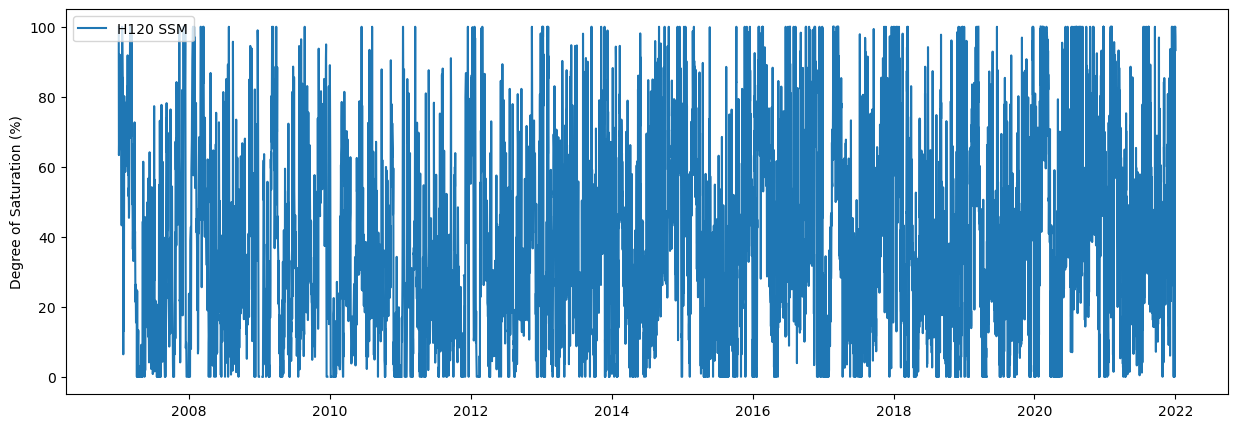

In [11]:
# show complete time series
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts['sm'], label='H120 SSM')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

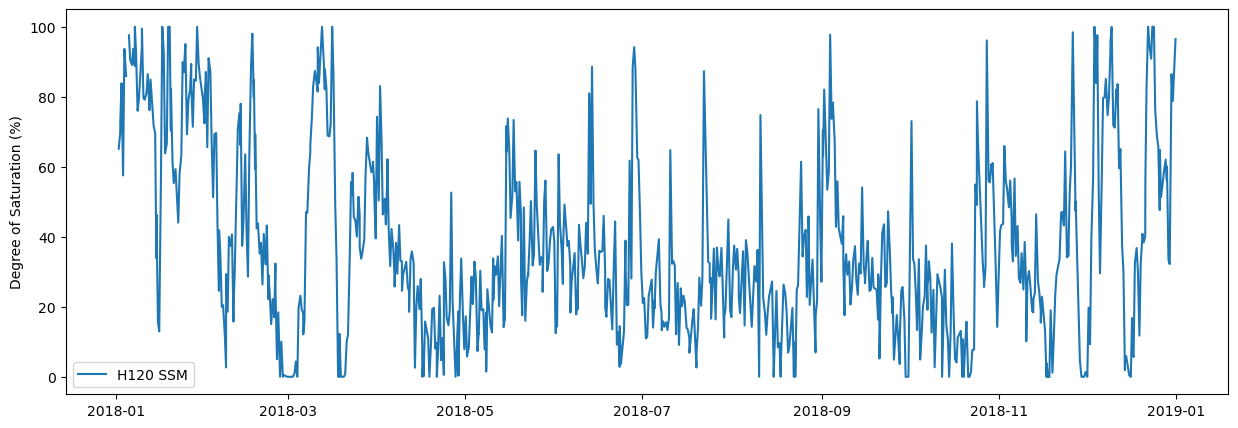

In [12]:
# show time series subset
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts.loc['2018', 'sm'],  label='H120 SSM')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

As discussed in the live session, soil moisture is affected by snow cover and frozen soils. We can see this in the subset of 2018, where a clear drop in soil moisture is visible in March, which is not likely due to changes in soil moisture. 
Hence we mask for frozen soils and snow cover using the probability mask. Please note, this is not the same as masking using in situ data or model data, but only a probability of that these conditions occur.

## Calculate VOD for exercise 2
In exercise 2 you will need an estimate for TAU or the so-called VOD. TAU can be calculated from Metop ASCAT observables and this is done in the code below. VOD is written to the data frame of the ASCAT data, and when you temporally match the data with the ISMN data then you can store the dataframe including VOD.  

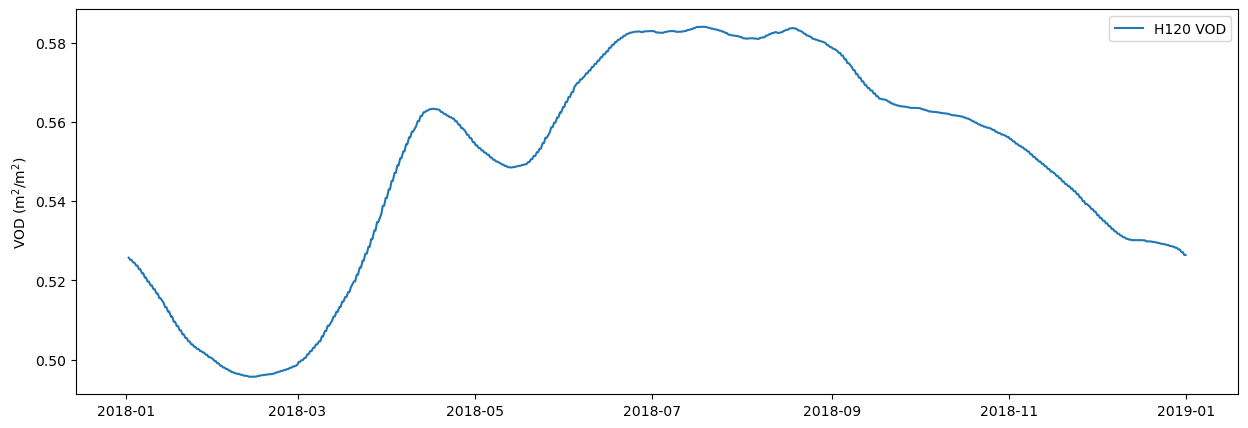

In [13]:
# convert all backscatter to the dry reference cross over angle of 25
sig25 = h120_ts.sigma40 + h120_ts.slope40 * (25 - 40) + \
        0.5 * h120_ts.curvature40 * (25 - 40) ** 2.
# get the lowest backscatter 
dry_25 = np.percentile(sig25, 5)
# convert to the reference angle of 40
dry_ref = dry_25 - h120_ts.slope40 * (25 - 40) - \
        0.5 * h120_ts.curvature40 * (25 - 40) ** 2
# get the wet reference 
wet_ref = np.percentile(h120_ts.sigma40, 95)

#set bare soil sensitivity
lin_bs_sens=0.21
# convert to linear domain
lin_wet_ref = 10**(wet_ref / 10.)
lin_dry_ref = 10**(dry_ref / 10.)
# get total backscatter sensitivity
lin_sens = lin_wet_ref - lin_dry_ref
inc_angle = -np.cos(np.radians(40)) / 2.
# calculate vod as ratio between bare soil sensitivity and total backscatter sensitivity
# and store it in the h120 dataframe
h120_ts.loc[:, 'vod'] = inc_angle * np.log(lin_sens / lin_bs_sens)
# show time series of VOD 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts.loc['2018', 'vod'],  label='H120 VOD')
ax.set_ylabel(r'VOD (m$^2$/m$^2$)')
ax.legend()
plt.show()

## Temporal matching
The data of the in situ station and the satellite observations do not match, e.g. the satellite data is available from 2007 to 2021, the in situ station only since 2014 in my case, the observation times are different with satellite observation irregular between 6 and 10 AM/PM and the in situ data at hourly intervals. So these two datasets need to be matched in time in order to have the same amount of observations. Here it is best practice to match to the most sparse dataset, in our case the ASCAT data. 

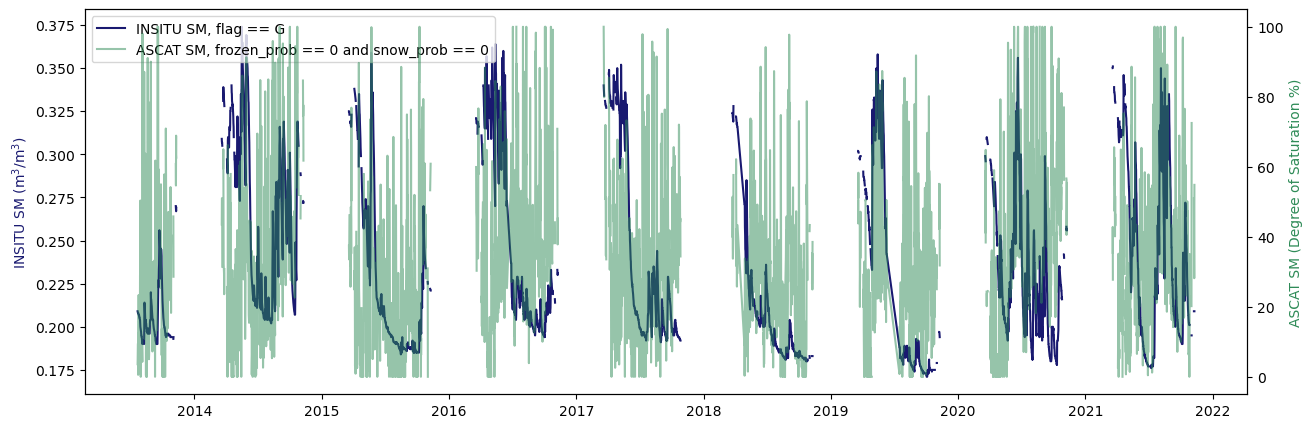

In [14]:
# do a temporal matching of the two datasets to find the closest in situ observation to the satellite observation.
# the window of 1 means that the maximum distance between the observations is 1 day. 
insitu_match = tmatch.df_match(h120_ts, insitu_ts, window=1)
df = h120_ts.join(insitu_match)
# we can use the provided flags from the in situ and satellite data sets to mask our data
# for outliers and frozen soils and snow cover.
df_masked = df.loc[df['soil_moisture_flag']=='G',:]
mask = (df_masked['frozen_prob'] > 0) | (df_masked['snow_prob'] > 0)
df_masked = df_masked.mask(mask)

# Let's store our matched dataframe to our workspace so we can easily use it in the next exercises!
df_masked.to_csv(os.path.join(workspace_path, 'matched_df.csv'))

# We can make a graphic to check our datasets and the matching!
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax2=ax.twinx()
lns1=ax.plot(df_masked[['soil_moisture']],label='INSITU SM, flag == G', c='midnightblue')
lns2=ax2.plot(df_masked['sm'], color='seagreen', label='ASCAT SM, frozen_prob == 0 and snow_prob == 0', alpha=0.5)
ax2.set_ylabel('ASCAT SM (Degree of Saturation %)', c='seagreen')
ax.set_ylabel(r'INSITU SM (m$^3$/m$^3$)', c='midnightblue')
lns = lns1+lns2 # this is to combine the legends from the two axes
labs = [l.get_label() for l in lns] # this is to combine the legends from the two axes
ax.legend(lns, labs, loc=2)
#store the figure to the workspace
plt.savefig(os.path.join(workspace_path, 'matched_insitu_ascat.png'))

## Exercise
To complete the exercise, please locate an ISMN station of your interest, download the ISMN data, read in the data using the longitude and latitude. Do a temporal matching of the data and plot the time series as shown below and upload this to the Padlet with a description and first interpretation. If necessary, save your matched dataframe (see below) so you have it ready for the other exercises.